### Set up

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

env = gym.make('CliffWalking-v0')

#Ref: https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/cliff_walking.py


### Parent class

In [3]:
class TemporalDifference:
  def __init__(self, epsilon = 0.1, max_steps = 70, alpha = 0.5, gamma = 1, total_episode = 500, no_run = 101):
    self.epsilon, self.max_steps, self.alpha, self.gamma, self.total_episode = epsilon, max_steps, alpha, gamma, total_episode
    self.no_run = list(range(1,no_run))
    

  #Function to choose the next action
  def choose_action(self, Q, state):
      if np.random.uniform(0, 1) < self.epsilon:
          action = env.action_space.sample()
      else:
          action = np.argmax(Q[state, :])
      return action

  def learning(self, learning_algorithm):
    #Initializing the Q-matrix and sum of rewards per episode

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_optimal_rewards = np.zeros(self.total_episode)

    # Starting learning
    for i in self.no_run: 
      for episode in range(self.total_episode):
        t = 0
        state1 = env.reset() 
        action1 = self.choose_action(Q, state1)
        done = False

        while t < self.max_steps and not done:
          #Getting the next state
          state2, reward, done, info = env.step(action1)
          action2 = self.choose_action(Q, state2) #the difference between SARSA and Q-Learning

          #Learning the Q-value
          Q = learning_algorithm(Q, state1, state2, reward, action1, action2)

          state1 = state2
          action1 = action2
            
          #Updating timestep
          t += 1

        #run one episode with the epsilon-greedy policy with the learnt Q
        t_optimal = 0
        state1 = env.reset() 
        done = False
        optimal_reward = 0
        while t_optimal < self.max_steps and not done:
          action1 = self.choose_action(Q, state1)
          state2, reward, done, info = env.step(action1)
          state1= state2
          t_optimal += 1
          optimal_reward += reward

        total_optimal_rewards[episode] += optimal_reward
    return Q, total_optimal_rewards          

  # find best policy using the latest Q value
  def best_policy(self, Q):
    policy = np.argmax(Q, axis = -1)
    actions = ["^", ">", "v", "<"]
    policy_arrows = [actions[i] for i in policy]
    return pd.DataFrame(np.array(policy_arrows).reshape(4,12))
    

  def __repr__(self): #for description of object
    return f"Sarsa({self.epsilon}, {self.max_steps}, {self.alpha}, {self.gamma}, {self.total_episode}, {len(self.no_run)})"
  

### Subclasses

In [4]:
class Sarsa(TemporalDifference):
  #Function to learn the Q-value for a SARSA agent
  def update_Q(self, Q, state, state2, reward, action, action2):
      predict = Q[state, action]
      target = reward + self.gamma * Q[state2, action2]
      Q[state, action] = Q[state, action] + self.alpha * (target - predict)
      Q[47, :] = 0
      return Q

  def learning(self):
    print("Sarsas learning")
    return super().learning(self.update_Q)



In [5]:
class Q_Learning(TemporalDifference):
  #Function to learn the Q-value for a Q-Learning agent
  def update_Q(self, Q, state, state2, reward, action, *args):
      predict = Q[state, action]
      action_best = np.argmax(Q[state2,:], axis = -1)
      target = reward + self.gamma * Q[state2, action_best]
      Q[state, action] = Q[state, action] + self.alpha * (target - predict)
      Q[47, :] = 0
      return Q

  def learning(self):
    print("Q-Learning learning")
    return super().learning(self.update_Q)

### Training and getting best policy

In [6]:
s1 = Sarsa(total_episode = 10)
Q, total_optimal_rewards_sarsa = s1.learning()
s1.best_policy(Q)



Sarsas learning


,0,1,2,3,4,5,6,7,8,9,10,11
0,<,>,>,v,>,>,>,>,>,>,v,<
1,^,>,<,>,^,<,>,^,^,>,>,v
2,^,<,<,^,<,^,^,<,^,^,^,v
3,^,^,^,^,^,^,^,^,^,^,^,^


In [7]:
q1 = Q_Learning(total_episode = 10)
Q, total_optimal_rewards_q = q1.learning()
q1.best_policy(Q)

Q-Learning learning


,0,1,2,3,4,5,6,7,8,9,10,11
0,v,v,v,>,>,>,>,v,>,>,>,v
1,v,>,v,>,v,>,>,>,>,v,>,v
2,>,>,>,>,>,>,>,>,>,>,>,v
3,^,^,^,^,^,^,^,^,^,^,^,^


### Comparison between TD algorithms

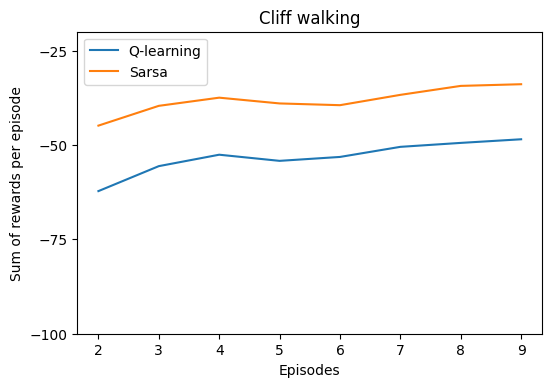

In [8]:
import seaborn as sns
fig = plt.figure(dpi=100)
ax = plt.axes()
q_sarsa_matrix = np.array([total_optimal_rewards_q, total_optimal_rewards_sarsa]).transpose()
df = pd.DataFrame(q_sarsa_matrix, columns = ["Q-learning", "Sarsa"])
df["Q-learning"] /= 100
df["Sarsa"] /= 100
df['MA_Q-learning'] = df["Q-learning"].rolling(window=3).mean()
df['MA_Sarsa'] = df["Sarsa"].rolling(window=3).mean()


ax = sns.lineplot(data=df, x = df.index, y = "MA_Q-learning")
ax = sns.lineplot(data=df, x = df.index, y = "MA_Sarsa")
ax.set(title="Cliff walking", xlabel="Episodes", ylabel = "Sum of rewards per episode", yticks = range(-100, -20, 25))
ax.set_ylim(-100,-20)
ax.legend(["Q-learning", "Sarsa"])